In [1]:
# Use rpy2 for loading R datasets
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import data as rdata
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

# Math and data processing
import numpy as np
import scipy as sp
import pandas as pd

# StatsModels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# scikit-learn
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

# Visulization
from IPython.display import display
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.style.use('ggplot')
import pydotplus

# Lab 8.3.1 Fitting Classification Trees

In [2]:
# wage dataset is in R ISLR package
islr = importr('ISLR')
carseats_rdf = rdata(islr).fetch('Carseats')['Carseats']
with localconverter(ro.default_converter + pandas2ri.converter):
  carseats = ro.conversion.rpy2py(carseats_rdf)
display(carseats.head(5))

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
1,9.50,138.0,73.0,11.0,276.0,120.0,Bad,42.0,17.0,Yes,Yes
2,11.22,111.0,48.0,16.0,260.0,83.0,Good,65.0,10.0,Yes,Yes
3,10.06,113.0,35.0,10.0,269.0,80.0,Medium,59.0,12.0,Yes,Yes
4,7.40,117.0,100.0,4.0,466.0,97.0,Medium,55.0,14.0,Yes,Yes
5,4.15,141.0,64.0,3.0,340.0,128.0,Bad,38.0,13.0,Yes,No


In [3]:
# Coding qualitative variables
carseats['High'] = (carseats.Sales > 8).astype('int')
carseats['ShelveLoc'] = carseats.ShelveLoc.map({'Bad':0, 'Good':1, 'Medium':2})
carseats['Urban'] = (carseats.Urban == 'Yes').astype('int')
carseats['US'] = (carseats.US == 'Yes').astype('int')
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
1,9.50,138.0,73.0,11.0,276.0,120.0,0,42.0,17.0,1,1,1
2,11.22,111.0,48.0,16.0,260.0,83.0,1,65.0,10.0,1,1,1
3,10.06,113.0,35.0,10.0,269.0,80.0,2,59.0,12.0,1,1,1
4,7.40,117.0,100.0,4.0,466.0,97.0,2,55.0,14.0,1,1,0
5,4.15,141.0,64.0,3.0,340.0,128.0,0,38.0,13.0,1,0,0


In [4]:
# Decision tree classification, on the whole data set.
# Use max_depth to limit tree size, since manual pruning is not implemented in scikit-learn.
X = carseats.drop(['Sales', 'High'], axis=1)
y = carseats['High']
tree = DecisionTreeClassifier(max_depth=6)
tree.fit(X, y)
score = tree.score(X, y)
print("Training error rate = ", 1-score)
print("Tree node size =", tree.tree_.node_count)

Training error rate =  0.08250000000000002
Tree node size = 65


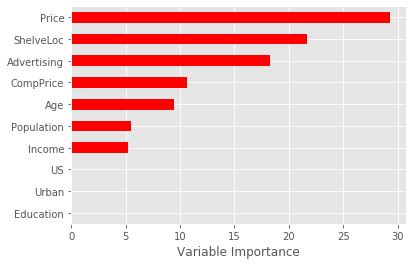

In [5]:
# Feature Importance
Importance = pd.DataFrame({'Importance':tree.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [6]:
# Decision tree classification, on training set only.
# Use max_depth to limit tree size, since manual pruning is not implemented in scikit-learn.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=12)
tree = DecisionTreeClassifier(max_depth=6)
tree.fit(X_train, y_train)
score = tree.score(X_train, y_train)
print("Training error rate = ", 1-score)
print("Tree node size =", tree.tree_.node_count)

Training error rate =  0.015000000000000013
Tree node size = 61


In [7]:
# Prediction
y_pred = tree.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred))
cm = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print('Confusion matrix:\n', cm)

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76       118
           1       0.66      0.72      0.69        82

    accuracy                           0.73       200
   macro avg       0.72      0.73      0.72       200
weighted avg       0.74      0.73      0.73       200

Confusion matrix:
      No  Yes
No   87   23
Yes  31   59


# Lab 8.3.2 Fitting Regression Trees

In [8]:
# wage dataset is in R ISLR package
mass = importr('MASS')
boston_rdf = rdata(mass).fetch('Boston')['Boston']
with localconverter(ro.default_converter + pandas2ri.converter):
  boston = ro.conversion.rpy2py(boston_rdf)
display(boston.head(5))

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [9]:
# Tree regression and prediction
X = boston.drop('medv', axis=1)
y = boston['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=12)
tree_regr = DecisionTreeRegressor(max_depth=3)  # No pruning in scikit-learn
tree_regr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

MSE =  22.428534221948354


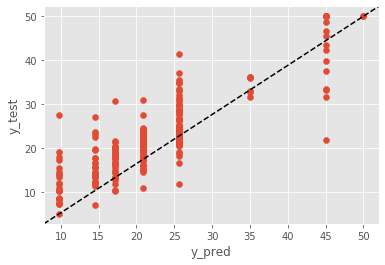

In [10]:
# Prediction
y_pred = tree_regr.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))
plt.scatter(y_pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

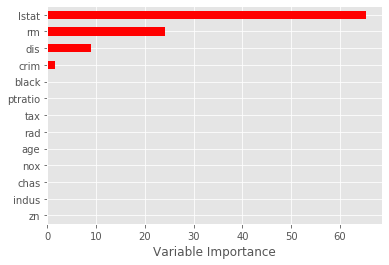

In [11]:
# Feature Importance
importance = pd.DataFrame({'Importance':tree_regr.feature_importances_*100}, index=X.columns)
importance = importance.sort_values('Importance', axis=0, ascending=True)
importance.plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None


# Lab 8.3.3 Bagging and Random Forests

In [12]:
# Random forest with 13 features
rf13 = RandomForestRegressor(max_features=13, random_state=12)
rf13.fit(X_train, y_train)
y_pred = rf13.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

MSE =  12.819981237154147


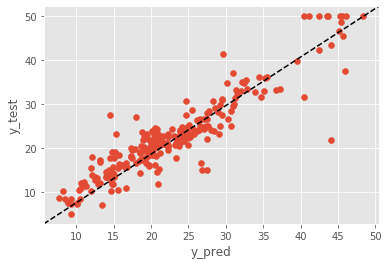

In [13]:
plt.scatter(y_pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [14]:
# Random forest with 6 features
rf6 = RandomForestRegressor(max_features=6, random_state=12)
rf6.fit(X_train, y_train)
y_pred = rf6.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

MSE =  11.01929509090909


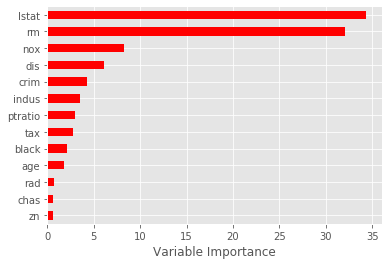

In [15]:
# Feature importance
importance = pd.DataFrame({'Importance':rf6.feature_importances_*100}, index=X.columns)
importance = importance.sort_values('Importance', axis=0, ascending=True)
importance.plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# Lab 8.3.4 Boosting

In [16]:
gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=12)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

MSE =  11.974388911917202


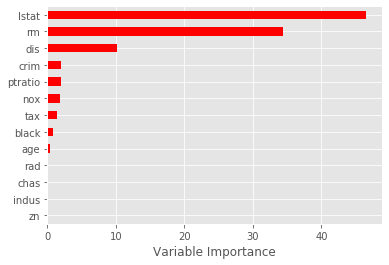

In [17]:
# Feature importance
importance = pd.DataFrame({'Importance':gbr.feature_importances_*100}, index=X.columns)
importance = importance.sort_values('Importance', axis=0, ascending=True)
importance.plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [18]:
importance

,Importance
zn,0.010103
indus,0.072136
chas,0.099669
rad,0.114440
age,0.386041
black,0.785752
tax,1.435900
nox,1.917000
ptratio,2.048583
crim,2.065908
